In [2]:
import psycopg2
import pandas as pd 
# from sqlalchemy.types import Integer, Text, String, DateTime
import sqlalchemy as s
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = s.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
repo_list = pd.DataFrame()
repo_list_query = f"""
SELECT repo_id, repo_name, repo_path from repo
WHERE repo_name = 'concourse' OR repo_name = 'postfacto' or repo_name = 'clarity' or repo_name = 'gpdb' or
      repo_name = 'kpack' or repo_name = 'rabbitmq-server' or repo_name = 'sonobuoy' or repo_name = 'velero' 
      or repo_name = 'octant' or repo_name = 'gpdb';
    """
repo_list = pd.read_sql_query(repo_list_query, con=engine)
print(repo_list)

    repo_id        repo_name                              repo_path
0     28037           octant               github.com/vmware-tanzu/
1     27169             gpdb                github.com/pivotal-gss/
2     28031           velero               github.com/vmware-tanzu/
3     28051        concourse                  github.com/concourse/
4     27043            kpack                    github.com/pivotal/
5     25432  rabbitmq-server                   github.com/rabbitmq/
6     25857             gpdb               github.com/greenplum-db/
7     27913          clarity                     github.com/vmware/
8     28030         sonobuoy               github.com/vmware-tanzu/
9     26600             gpdb  github.com/Pivotal-Field-Engineering/
10    26983        postfacto                    github.com/pivotal/
11    26235        concourse               github.com/pcfdev-forks/


In [4]:
## List of repository IDs for the report
#repo_dict = {25760, 25663} #spring-boot & spring-framework
#repo_dict = {28051} # concourse
#repo_dict = {26983} #postfacto
#repo_dict = {25432} #rabbitmq-server
#repo_dict = {25663} #spring-framework
#repo_dict = {28030} #sonobuoy
#repo_dict = {28031} #velero
#repo_dict = {27913} #clarity
#repo_dict = {28037} #octant
#repo_dict = {25857} #gpdb
repo_dict = {28046}

In [5]:
#from datetime import date
import datetime 

current = datetime.date.today()
today = "'" + str(current) + "'"
#print(current)

first_current = current.replace(day=1)
last_month = first_current - datetime.timedelta(days=1)
end_date = "'" + str(last_month) + "'"
#print(end_date)

start = last_month - datetime.timedelta(days=365)
year_ago = "'" + str(start) + "'"
#print(year_ago)

In [6]:
#Commit data - from humans excluding known bots
commitsDF = pd.DataFrame()
for value in repo_dict: 
    commitsquery = f"""
                    SELECT
                        DISTINCT(cmt_commit_hash),
                        CASE WHEN contributors.cntrb_canonical IS NOT NULL THEN contributors.cntrb_canonical ELSE cmt_author_email END AS cntrb_canonical,
                        CASE WHEN canonical_full_names.cntrb_full_name IS NOT NULL THEN canonical_full_names.cntrb_full_name ELSE cmt_author_name END AS canonical_full_name,
                        cmt_author_name, cmt_author_email, repo_id, cmt_author_timestamp 
                    FROM commits 
                        LEFT OUTER JOIN contributors ON cntrb_email = cmt_author_email
                        LEFT OUTER JOIN (
                            SELECT cntrb_canonical, cntrb_full_name 
                            FROM contributors
                            WHERE cntrb_canonical = cntrb_email
                        ) canonical_full_names
                        ON canonical_full_names.cntrb_canonical = contributors.cntrb_canonical
                    WHERE
                        repo_id = {value}
                        AND cmt_author_name NOT LIKE 'snyk%%'
                        AND cmt_author_name NOT LIKE '%%bot'
                        AND cmt_author_name != 'Spring Operator'
                        AND cmt_author_name != 'Spring Buildmaster'
                         AND cmt_author_timestamp >= {year_ago}
                         AND cmt_author_timestamp <= {end_date}
                    ORDER BY
                        cntrb_canonical;
                    """
    
    get_repo_name_query = f"""
        SELECT repo_name from repo where repo_id = {value};
           """
    get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
    repo_name = get_repo_name.repo_name[0]
    
commitsDF = pd.read_sql_query(commitsquery, con=engine)
total_commits = commitsDF.cmt_commit_hash.nunique()                     

In [7]:
authorDF = pd.DataFrame()
authorDF = commitsDF.cntrb_canonical.value_counts()
authorDF = authorDF.reset_index()
authorDF.columns = ['email', 'commits']
authorDF['percent'] = authorDF['commits'] / total_commits
print(authorDF.head(10))
print()

                      email  commits   percent
0       lintongj@vmware.com       69  0.436709
1   dsmithuchida@vmware.com       48  0.303797
2  ssrinivasaiah@vmware.com       32  0.202532
3        wxinyan@vmware.com       22  0.139241
4    chin-ya.huang@suse.com        3  0.018987



In [8]:
authorDF = pd.DataFrame()
authorDF = commitsDF.canonical_full_name.value_counts()
authorDF = authorDF.reset_index()
authorDF.columns = ['name', 'commits']
authorDF['percent'] = authorDF['commits'] / total_commits
print(authorDF.head(10))

                    name  commits   percent
0          Lintong Jiang       69  0.436709
1  David L. Smith-Uchida       48  0.303797
2              Xinyan Wu       22  0.139241
3  Santhosh Srinivasaiah       16  0.101266
4             Santhosh S       16  0.101266
5              c3y1huang        3  0.018987


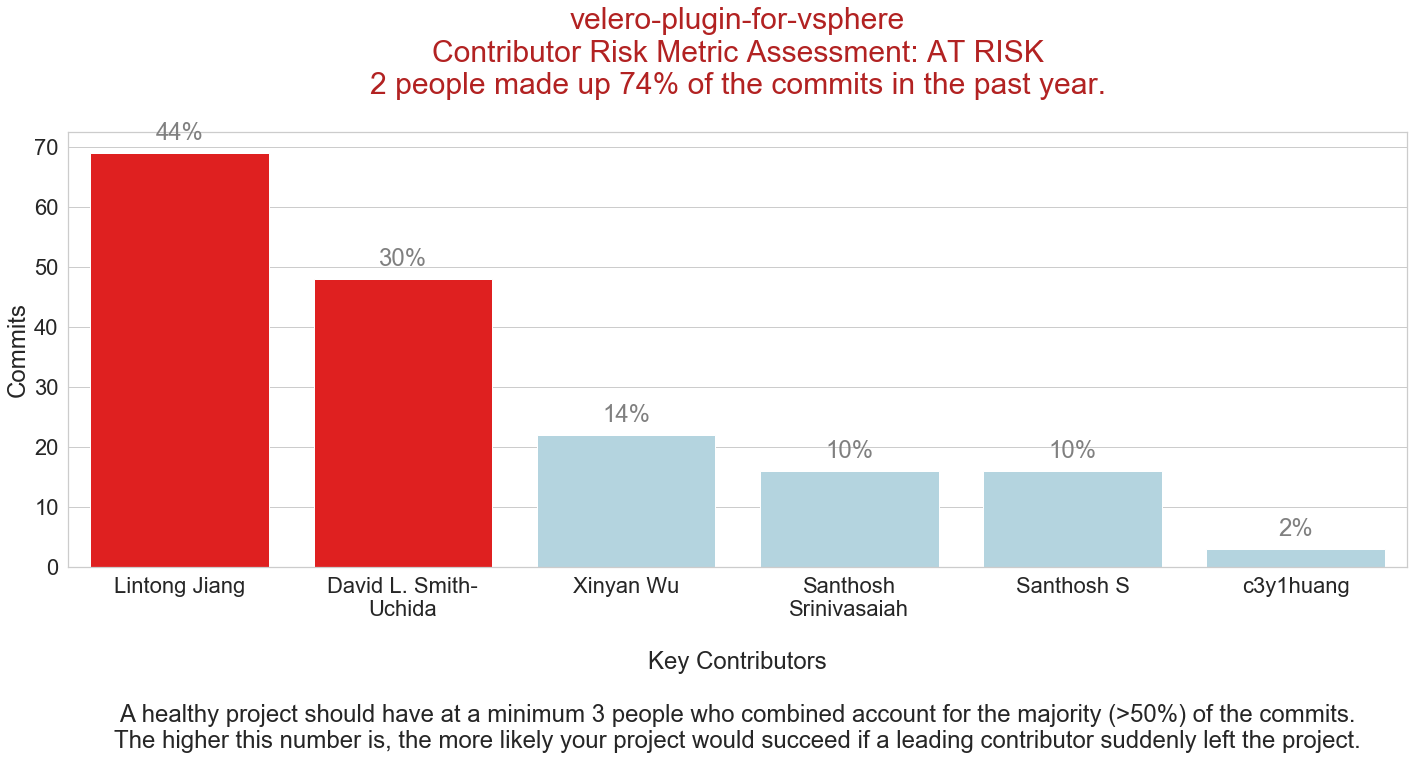

In [9]:
import textwrap

cum_percent = 0
people_list = []

i = 1
num_people = 0

for item in authorDF.iterrows():
    name = item[1]['name']
    percent = item[1]['percent']
    commits = item[1]['commits']
    
    cum_percent += percent
    
    people_list.append([name, percent, commits])
    
    if (cum_percent > .50 and num_people == 0):
        num_people = i
        risk_percent = cum_percent
        
    if i == 8:
        if cum_percent <= .50:
            risk_percent = cum_percent
            num_people = i
        break
    i+=1
    
risk_list = []
bar_colors = []

j = 1
for person in people_list:
    name = person[0]
    if len(name) > 15:
        new_name = textwrap.wrap(name, 15)
        name = '\n'.join(new_name)
    percent = person[1]
    commits = person[2]
    risk_list.append([name, percent, commits])
    
    if (num_people < 3 and j <= num_people):
        bar_colors.append('red')
    else:
        bar_colors.append('lightblue')
    
    j+=1
    

names = [item[0] for item in risk_list]
percents = [item[1] for item in risk_list]
commits = [item[2] for item in risk_list]

sns.set_style('ticks')
sns.set(style="whitegrid", font_scale=2)

fig, ax = plt.subplots()

# the size of A4 paper
fig.set_size_inches(24, 8)

title = repo_name + "\nContributor Risk Metric Assessment: "

if num_people < 3:
    title += "AT RISK"
    title_color = 'firebrick'
else:
    title += "Healthy"
    title_color = 'forestgreen'
title += "\n" + str(num_people) + " people made up " + "{:.0%}".format(risk_percent) + " of the commits in the past year.\n"

risk_bar = sns.barplot(x=names, y=commits, palette=bar_colors).set_title(title, fontsize=30, color=title_color)

risk_bar_labels = ax.set_xticklabels(names, wrap=True)
risk_bar_labels = ax.set_ylabel('Commits')
risk_bar_labels = ax.set_xlabel('\nKey Contributors\n\nA healthy project should have at a minimum 3 people who combined account for the majority (>50%) of the commits.\nThe higher this number is, the more likely your project would succeed if a leading contributor suddenly left the project.')

i = 0
for p in ax.patches:
    ax.annotate("{:.0%}".format(percents[i]), (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', color='gray', xytext=(0, 20),
        textcoords='offset points')
    i+=1

## Misc data exploration
Trying to understand what's happening with the multiple canonical names

In [42]:
test = commitsDF.loc[commitsDF['cntrb_canonical'] == 'jrosland@vmware.com'].canonical_full_name
print(test[402])

Jonas Rosland


In [48]:
commitsDF.loc[commitsDF['cntrb_canonical'] == 'bryanliles@gmail.com']

,cmt_commit_hash,cntrb_canonical,canonical_full_name,cmt_author_name,cmt_author_email,repo_id,cmt_author_timestamp
28,005fba92f6b43beab5b788c4803c154da87160f1,bryanliles@gmail.com,bryanl,bryanl,bryanliles@gmail.com,28037,2019-04-04 00:09:16+00:00
29,00b5c25e697375d3a58c0eabcfb53e878ab6f060,bryanliles@gmail.com,Bryan Liles,Bryan Liles,bryanliles@gmail.com,28037,2019-04-18 19:07:00+00:00
30,00fac7d8aa415772fdbd69af800a4b36e98865a2,bryanliles@gmail.com,bryanl,bryanl,bryanliles@gmail.com,28037,2019-08-03 13:51:51+00:00
31,02c9ffaa4350b832aca7dd050911ea24d2bd9cbf,bryanliles@gmail.com,lilesb,lilesb,bryanliles@gmail.com,28037,2019-09-15 20:23:59+00:00
32,02e4c929af1e21cfb45774804ff5e94a018a6aa4,bryanliles@gmail.com,bryanl,bryanl,bryanliles@gmail.com,28037,2019-06-11 18:51:13+00:00
...,...,...,...,...,...,...,...
377,fc3a26d05f70cb2be80246d5f8ea26562fb03976,bryanliles@gmail.com,bryanl,bryanl,bryanliles@gmail.com,28037,2019-03-13 19:26:45+00:00
378,fcb5a2ca48210c6c108cb165421fcdfdc88c5b29,bryanliles@gmail.com,Bryan Liles,Bryan Liles,bryanliles@gmail.com,28037,2020-02-20 14:07:57+00:00
379,fd44145165a6e47f86d3e51bc9536130cd019258,bryanliles@gmail.com,Bryan Liles,Bryan Liles,bryanliles@gmail.com,28037,2019-04-08 16:09:13+00:00
380,fe36a3665e587de53f20cf551e86729f9066b972,bryanliles@gmail.com,Bryan Liles,Bryan Liles,bryanliles@gmail.com,28037,2019-07-22 17:11:18+00:00
